# CRC-VAL-HE-7K image classification

The dataset Colorectal Cacner-Validation-Histology-7K (CRC-VAL-HE-7K) consist of 7180 images extracted from 50 patients with colorectal adenocarcinoma and were used to create a dataset that does not overlap with patients in the NCT-CRC-HE-100K dataset. It was created by pathologists by manually delineating tissue regions in whole slide images into the following nine tissue classes: Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM).

### 1 IMPORT AND PREPROCESS THE DATA
#### 1.1 Libraries required

In [ ]:
!pip install opencv-python
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns

!pip install split-folders
import splitfolders

#### 1.2 Import and preprocess the data

We first need to create a train (70%) and a validation (30%) folder inside the general folder we have. For that we use split-folders.

In [ ]:
splitfolders.ratio("C:\\Users\\HelenaVillaresSantia\\Downloads\\CRC-VAL-HE-7K", output="crc7k1",seed=1337, ratio=(.7, .3), group_prefix=None, move=False)

Copying files: 7180 files [00:23, 301.98 files/s]


We print the folders inside the new folder created above (the output defined). Also, we define the dimensions we will resize our images to (same x and y).

In [ ]:
print(os.listdir("C:/Users/HelenaVillaresSantia/crc7k1/"))

#SIZE = 128 
SIZE=64

['train', 'val']


### 1.3 Data distribution
Run until the reassignment of the split data names to the meaningful convention before running this cell.

C:\Users\HelenaVillaresSantia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\HelenaVillaresSantia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


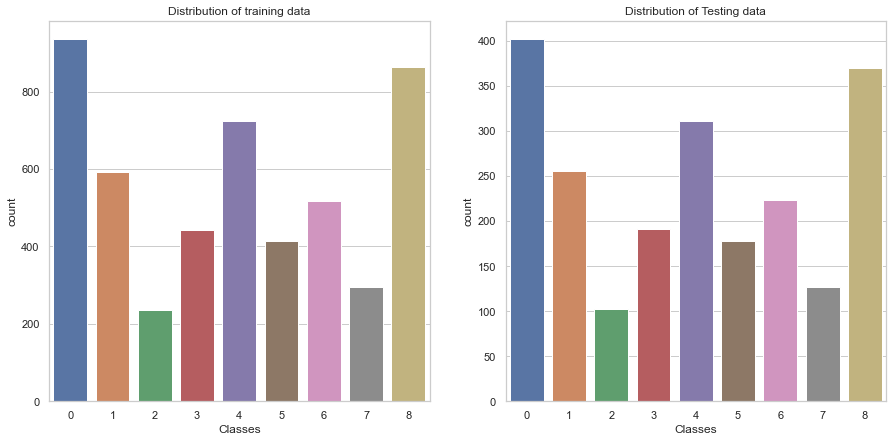

In [ ]:
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(1,2,figsize=(15,7)) 

sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

### 1.4 Images to Arrays

In [ ]:
train_images = []
train_labels = [] 
for directory_path in glob.glob(r"C:\Users\HelenaVillaresSantia\crc7k1\train\*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img) # append img to the empty list opened before
        train_labels.append(label)# for which img it says which the correspondent label is
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)


ADI
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-AAKTCYHC.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-ACCKVFLM.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-ADCVKMNS.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-ADEFMGRC.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-ADTVLITV.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-AECFTNDT.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-AEDALKHL.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-AESDELDR.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-AFMNYIYL.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-AGWWSHFM.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-AICIMAWL.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-AILTQVKE.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-AIQQNFEC.tif
C:\Users\HelenaVillaresSantia\crc7k1\train\ADI\ADI-TCGA-AIVNNKLK.tif
C:\Users\HelenaVillaresSantia\

In [ ]:
# test
test_images = []
test_labels = [] 
for directory_path in glob.glob(r"C:\Users\HelenaVillaresSantia\crc7k1\val\*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#### Change labels from text to integers

In [ ]:
#change labels from text to integers --> eg. ADI=0, BACK=1, DEB=2 ...
from sklearn import preprocessing
le = preprocessing.LabelEncoder() # we can encode and then decode (we'll do it at the end!)
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#### Reassign split data names the meaningful convention

In [ ]:
x_train, x_test, y_train, y_test = train_images, test_images, train_labels_encoded, test_labels_encoded

#### Rescale values from 0 to 1

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

#### One Hot Encoding

Ref. https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

In [ ]:
#One hot encode y values for neural network.
#HOT ENCODING: for each value creates an entire column, just one pixel each row will have a value of 1 
from tensorflow.keras.utils import to_categorical
y_train_hot = to_categorical(y_train, 9)
y_test_hot = to_categorical(y_test, 9)

### 2 CONVOLUTIONAL NEURAL NETWORK
#### 2.1 Deep Learning

In [ ]:
activation = 'sigmoid'

model = Sequential()
model.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))#32 filters
model.add(BatchNormalization())

model.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))#32 filters
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))#64 filters
model.add(BatchNormalization())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))#64 filters
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())#DONT'T miss the flatten layer between CNN and Dense layers
#flatten=becomes one column, NOT multi-dimensional

In [ ]:
#Add layers for DL prediction: take the model and add the last dense layers
x = model.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)#new x=dense applied on x
prediction_layer = Dense(9, activation = 'softmax')(x) # 9 classes!!!

In [ ]:
# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=model.input, outputs=prediction_layer)
#cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
#cnn_model.compile(optimizer='rmsprop',loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0     

### 2.2 Model train and validation data obtention

In [ ]:
history = cnn_model.fit(x_train, y_train_hot, epochs=50, validation_data = (x_test, y_test_hot))

Epoch 1/50
157/157 [==============================] - 305s 2s/step - loss: 0.8251 - accuracy: 0.7293 - val_loss: 3.3079 - val_accuracy: 0.0885
Epoch 2/50
157/157 [==============================] - 275s 2s/step - loss: 0.5467 - accuracy: 0.8194 - val_loss: 2.0220 - val_accuracy: 0.4164
Epoch 3/50
157/157 [==============================] - 297s 2s/step - loss: 0.4606 - accuracy: 0.8486 - val_loss: 1.7489 - val_accuracy: 0.4947
Epoch 4/50
157/157 [==============================] - 285s 2s/step - loss: 0.3772 - accuracy: 0.8787 - val_loss: 0.9021 - val_accuracy: 0.7170
Epoch 5/50
157/157 [==============================] - 273s 2s/step - loss: 0.3475 - accuracy: 0.8833 - val_loss: 0.5427 - val_accuracy: 0.7967
Epoch 6/50
157/157 [==============================] - 278s 2s/step - loss: 0.3205 - accuracy: 0.8936 - val_loss: 1.3367 - val_accuracy: 0.6642
Epoch 7/50
157/157 [==============================] - 276s 2s/step - loss: 0.2752 - accuracy: 0.9086 - val_loss: 1.4965 - val_accuracy: 0.5947

### 2.3 Model Evaluation

#### Training and validation loss at each epoch

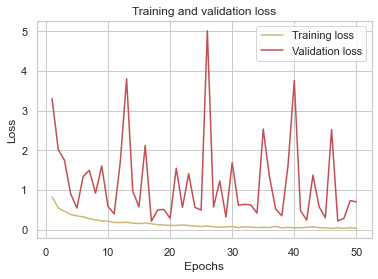

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Training and validation accuracy at each epoch

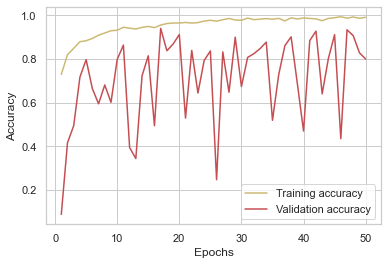

In [ ]:
#acc = history.history['acc']
#model.compile(loss="categorical_crossentropy", metrics=["acc"])
#val_acc = history.history['val_acc']
#model.compile(loss="categorical_crossentropy", metrics=["val_acc"])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2.4 Score trained model and prediction.

In [ ]:
# Score trained model.
scores = cnn_model.evaluate(x_test, y_test_hot, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

68/68 [==============================] - 22s 326ms/step - loss: 0.6976 - accuracy: 0.7994
Test loss: 0.6975846290588379
Test accuracy: 0.7994441986083984


### 2.5 Confusion Matrix
Verify the accuracy of each class.

In [ ]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

<AxesSubplot:>

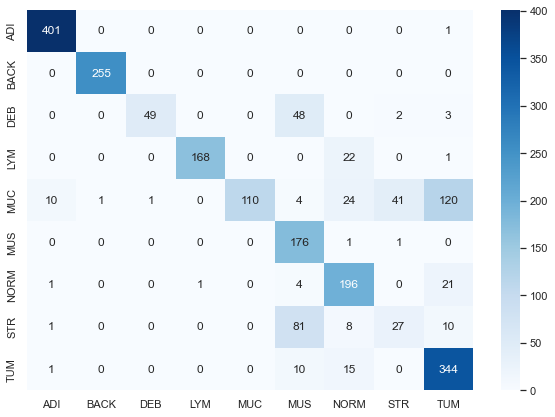

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
cm = confusion_matrix(test_labels, prediction_NN)
#print(cm)
df_cm = pd.DataFrame(cm, index = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'],
    columns = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,cmap=plt.cm.Blues,annot=True,fmt='d')

### 2.6 Check results on a few select images

The prediction for this image is:  ['TUM']
The actual label for this image is:  MUC


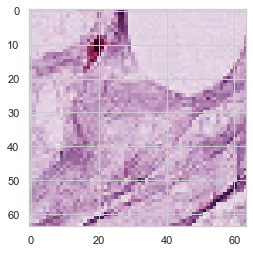

In [ ]:
n=1009  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = np.argmax(cnn_model.predict(input_img))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

### 3 RANDOM FOREST
#### 3.1 Model Training

In [ ]:
X_for_RF = model.predict(x_train) #This is out X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

#### 3.2 Model Validation

In [ ]:
#Send test data through same feature extractor process
X_test_feature = model.predict(x_test)
#Now predict using the trained RF model 
predRF = RF_model.predict(X_test_feature)
#Inverse le transform to get original label back
predRF = le.inverse_transform(predRF)

In [ ]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predRF)) #Print overall accuracy

Accuracy =  0.8828161185734136


#### 3.3 Confusion Matrix

<AxesSubplot:>

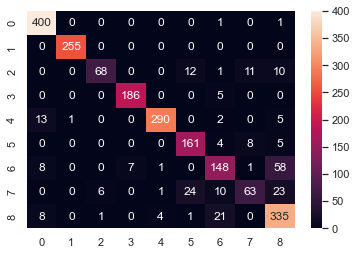

In [ ]:
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, predRF)
#print(cm)
sns.heatmap(cm, annot=True, fmt='d')

#### 3.4 Check results on a few select images

The prediction for this image is:  ['MUC']
The actual label for this image is:  MUC


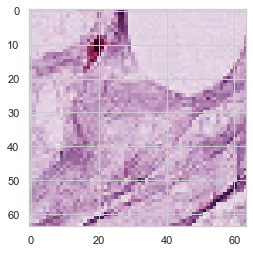

In [ ]:
n=1009 #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=model.predict(input_img)
predRF = RF_model.predict(input_img_features)[0] 
predRF = le.inverse_transform([predRF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", predRF)
print("The actual label for this image is: ", test_labels[n])

### 4 K-NEAREST NEIGHBOUR
#### 4.1 Model Training
We use the same train data we used for both CNN and RF.

In [ ]:
X_for_KNN = model.predict(x_train)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

In [ ]:
knn.fit(X_for_KNN, y_train)

KNeighborsClassifier()

#### 4.2 Model Validation

In [ ]:
X_test_KNN = model.predict(x_test)
predKNN = knn.predict(X_test_KNN)
predKNN = le.inverse_transform(predKNN)

In [ ]:
from sklearn import metrics
print('KNN Accuracy = ',  metrics.accuracy_score(test_labels,predKNN))

KNN Accuracy =  0.904122278832793


#### 4.3 Confusion Matrix

<AxesSubplot:>

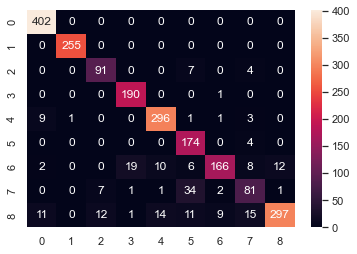

In [ ]:
cm = metrics.confusion_matrix(test_labels, predKNN)
#print(cm)
sns.heatmap(cm, annot=True,fmt='d')

#### 4.4 Check results on a few select images

The prediction for this image is:  ['MUC']
The actual label for this image is:  MUC


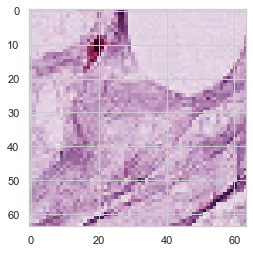

In [ ]:
n=1009 #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=model.predict(input_img)
predKNN = knn.predict(input_img_features)[0] 
predKNN = le.inverse_transform([predKNN])  #Reverse the label encoder to original name
print("The prediction for this image is: ", predKNN)
print("The actual label for this image is: ", test_labels[n])